In [ ]:
!pip install datasets transformers scikit-learn -q
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
df = pd.read_csv("training_data.csv")
df["text"] = (
    df[[f"post_{i}" for i in range(1, 41)]]
    .fillna("")
    .agg(" ".join, axis=1)
)
df["label"] = df["result"].map({"no": 0, "yes": 1})

ds = Dataset.from_pandas(df[["text", "label"]])


In [ ]:

split = ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds = split["train"]
val_ds   = split["test"]

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True)
train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)

data_collator = DataCollatorWithPadding(tokenizer)
train_ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
val_ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

In [ ]:
training_args = TrainingArguments(
    output_dir="./bert-finetuned",
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=200,
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('training_data.csv')

X = df.drop(columns=['result', 'yes_bid'])
y = df['result'].map({'no': 0, 'yes': 1})
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_cont = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred_cont)
print(f"Test MSE: {mse:.4f}")

y_pred_bin = (y_pred_cont >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_bin)
print(f"Thresholded Accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred_bin, target_names=['no','yes']))

Test MSE: 0.2241
Thresholded Accuracy: 0.6379

              precision    recall  f1-score   support

          no       0.43      0.23      0.30        39
         yes       0.68      0.84      0.76        77

    accuracy                           0.64       116
   macro avg       0.56      0.54      0.53       116
weighted avg       0.60      0.64      0.60       116



In [33]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

Test Accuracy: 0.6638

Classification Report:
              precision    recall  f1-score   support

          no       0.50      0.28      0.36        39
         yes       0.70      0.86      0.77        77

    accuracy                           0.66       116
   macro avg       0.60      0.57      0.57       116
weighted avg       0.63      0.66      0.63       116



In [32]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

Test Accuracy: 0.6897

Classification Report:
              precision    recall  f1-score   support

          no       0.56      0.38      0.45        39
         yes       0.73      0.84      0.78        77

    accuracy                           0.69       116
   macro avg       0.64      0.61      0.62       116
weighted avg       0.67      0.69      0.67       116



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

tf.keras.backend.clear_session()
try:
    del model
except NameError:
    pass

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.GaussianNoise(0.1),
    layers.Dense(32, activation='sigmoid',
                 kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=16,
    verbose=2
)

Epoch 1/30
26/26 - 1s - 35ms/step - accuracy: 0.4638 - loss: 0.8109 - val_accuracy: 0.5870 - val_loss: 0.7258
Epoch 2/30
26/26 - 0s - 3ms/step - accuracy: 0.5507 - loss: 0.7351 - val_accuracy: 0.5217 - val_loss: 0.7143
Epoch 3/30
26/26 - 0s - 4ms/step - accuracy: 0.5700 - loss: 0.7122 - val_accuracy: 0.5652 - val_loss: 0.7152
Epoch 4/30
26/26 - 0s - 4ms/step - accuracy: 0.6208 - loss: 0.7043 - val_accuracy: 0.5652 - val_loss: 0.7199
Epoch 5/30
26/26 - 0s - 4ms/step - accuracy: 0.6425 - loss: 0.6736 - val_accuracy: 0.5652 - val_loss: 0.7183
Epoch 6/30
26/26 - 0s - 4ms/step - accuracy: 0.6280 - loss: 0.6878 - val_accuracy: 0.5870 - val_loss: 0.7164
Epoch 7/30
26/26 - 0s - 4ms/step - accuracy: 0.6618 - loss: 0.6569 - val_accuracy: 0.5870 - val_loss: 0.7181
Epoch 8/30
26/26 - 0s - 4ms/step - accuracy: 0.6594 - loss: 0.6686 - val_accuracy: 0.6087 - val_loss: 0.7168
Epoch 9/30
26/26 - 0s - 4ms/step - accuracy: 0.6715 - loss: 0.6311 - val_accuracy: 0.6087 - val_loss: 0.7146
Epoch 10/30
26/26 

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc:.4f}")

y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['no','yes']))

Test accuracy: 0.6810
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report:
              precision    recall  f1-score   support

          no       0.58      0.18      0.27        39
         yes       0.69      0.94      0.80        77

    accuracy                           0.68       116
   macro avg       0.64      0.56      0.54       116
weighted avg       0.66      0.68      0.62       116



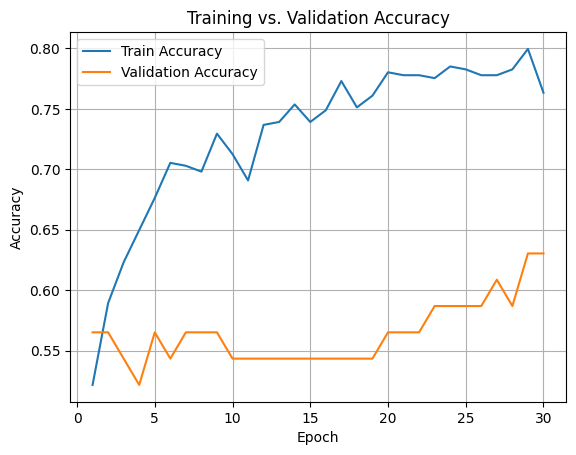

In [37]:
import matplotlib.pyplot as plt
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
epochs    = range(1, len(train_acc) + 1)

plt.figure()
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc,   label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
weights

array([1.47435897, 0.75657895])

In [ ]:
!pip install transformers datasets scikit-learn -q

In [ ]:
from datasets import load_dataset

# Load the IMDb dataset
dataset = load_dataset("imdb")
dataset = dataset.shuffle(seed=42)

# Split the dataset
train_data = dataset['train'].shuffle(seed=42).select(range(2000))  # smaller subset
test_data = dataset['test'].shuffle(seed=42).select(range(1000))

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)

In [ ]:
from transformers import BertForSequenceClassification

# Load BERT with a classification head
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

training_args = TrainingArguments(
    output_dir="./bert_output",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()